## Area for testing Code

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from dateutil import tz

In [36]:
from_zone = tz.gettz('UTC')
to_zone = tz.gettz('Europe/Vienna')

In [37]:
print(from_zone)
print(to_zone)

tzwin('UTC')
tzfile('Europe/Vienna')
tzlocal()


In [7]:
d=datetime.datetime.now()
str(d.date())

'2018-05-07'

In [2]:
path="./Data/2018/2.csv"
df = pd.read_csv(path, parse_dates=[4], index_col=[4])
st

In [135]:
(df.index[1]-df.index[0]) * 3

Timedelta('0 days 00:15:00')

# Data Viz over a whole Year each Month

In [2]:
from load_data import WeatherData, SummaryData
from visualize_data import Analyze_WD, get_year_start_end, get_month_start_end
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
### Do the Imports as in App (But without Gui)
wd = WeatherData()  # Load the Data
sd = SummaryData(wd) # Create The Statistics Object
v_wd = Analyze_WD(wd, sd=sd)  # Create the Analysis Object

In [23]:
def get_mean_month(year, col="MeanT"):
    """Apply function mean to Column col of 
    Summary Statistics Dataframe of year"""
    start_date, end_date = get_year_start_end(year)
    df = sd.give_summary_statistics(start_date, end_date)
    dfs = df.groupby(pd.Grouper(freq='M'))  ### Create Groupby Object by Month
    means_months = dfs[col].mean()
    return means_months

In [24]:
get_mean_month(2018)

2018-01-31     2.432821
2018-02-28    -1.490275
2018-03-31     2.799081
2018-04-30    14.870166
2018-05-31    17.883157
2018-06-30    20.046017
2018-07-31    21.431818
2018-08-31    22.143770
2018-09-30    16.748940
2018-10-31    12.568887
2018-11-30     5.808807
2018-12-31     1.764384
Freq: M, Name: MeanT, dtype: float64

In [21]:
def plot_meanT_years(years = [2017, 2018, 2019], col="MeanT", cmap="viridis", 
                     fs_l = 14, figsize=(10,5)):
    """Plot monthly mean Temperature over the Years.
    years: Which years to plot
    cmap: What color to plot"""
    cmap = cm.get_cmap(cmap)
    cmap_i = np.linspace(0,1,len(years))
    mean_months = [get_mean_month(year, col) for year in years]
    assert(len(mean_months)>0)   # Sanity Check

    x_vec = range(1, len(mean_months[0]) + 1)  # x-Vector to Plot

    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.set_ylabel("Monthly Mean Temperature [C]", fontsize=fs_l)
    ax.set_xlabel("Month", fontsize=fs_l)

    for i, y in enumerate(years):
        ax.plot(x_vec, mean_months[i].values, "o--", c=cmap(cmap_i[i]), label=y, lw=1, ms=8)
        ax.set_xticks(x_vec)
    plt.legend(fontsize = fs_l, loc="upper left")
    plt.show()

In [26]:
np.arange(2017,2019)

array([2017, 2018])

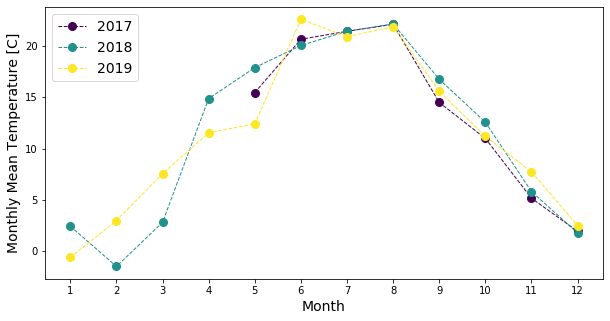

In [22]:
plot_meanT_years()

In [152]:
### Do Yearly Mean Temperature:
col = "MeanT"

for year in years:
    start_date, end_date = get_year_start_end(year)
    df = sd.give_summary_statistics(start_date, end_date)
    mean_year = np.nanmean(df[col])
    print(f"Year {year} Mean: {mean_year:.4f} C")

Year 2017 Mean: 13.7449 C
Year 2018 Mean: 11.0619 C
Year 2019 Mean: 11.5246 C


In [159]:
df

,MinT,MaxT,MeanT,TotR,TotS
2019-01-01,-2.6,6.7,2.7805,1.8,0.2250
2019-01-02,-1.3,5.2,2.0697,0.3,0.4449
2019-01-03,-3.3,-0.4,-1.7440,0.0,0.3861
2019-01-04,-3.9,0.2,-2.0910,0.0,0.5374
2019-01-05,0.3,3.4,1.6797,7.1,0.3396
2019-01-06,-1.3,2.7,1.3649,0.0,0.4235
2019-01-07,-3.6,-1.1,-2.3143,0.0,0.5003
2019-01-08,-2.7,2.8,-0.0804,7.1,0.3919
2019-01-09,0.0,3.3,1.4539,2.0,0.7787
2019-01-10,-1.4,2.0,0.2413,0.3,0.6309


### Get Summary for one Year

In [74]:
def give_stats_period(start_date, end_date, prt=True):
    """Print Statistics of a period"""
    df = sd.give_summary_statistics(start_date, end_date)
    mean_year = np.nanmean(df["MeanT"])
    rain_year = np.nansum(df["TotR"])
    sun_year = np.nansum(df["TotS"])
    n_frost = np.sum(df["MinT"]<0)
    n_ice = np.sum(df["MaxT"]<0)
    n_trop = np.sum(df["MinT"]>20)
    n_hot = np.sum(df["MaxT"]>30)

    ### Print
    if prt:
        print(f"{start_date} to {end_date}:")
        print(f"Mean Temp.:\t {mean_year:.4f} C")
        print(f"Sum Rain:\t {rain_year:.2f} ml")
        print(f"Sum Sun:\t {sun_year:.2f} kwH")
        print(f"Frost Days:\t {n_frost}")
        print(f"Ice Days:\t {n_ice}")
        print(f"Tropic Nights:\t {n_trop}")
        print(f"Hot Days:\t {n_hot}")

In [85]:
year = 2018
start_date, end_date = get_year_start_end(year)
give_stats_period(start_date, end_date)

2018-01-01 to 2018-12-31:
Mean Temp.:	 11.0619 C
Sum Rain:	 579.30 ml
Sum Sun:	 848.26 kwH
Frost Days:	 97
Ice Days:	 17
Tropic Nights:	 2
Hot Days:	 45


In [86]:
year = 2019
start_date, end_date = get_year_start_end(year)
give_stats_period(start_date, end_date)

2019-01-01 to 2019-12-31:
Mean Temp.:	 11.5246 C
Sum Rain:	 641.30 ml
Sum Sun:	 784.25 kwH
Frost Days:	 96
Ice Days:	 5
Tropic Nights:	 0
Hot Days:	 57
